In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [3]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 3.7 MB/s eta 0:00:00


In [4]:
import shap

In [6]:
df = pd.read_csv("/content/Churn_Modelling.csv")
print(df.head())
print(df.info())
print(df.describe())

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

In [7]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df = pd.get_dummies(df, drop_first=True)
X = df.drop('Exited', axis=1)
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [8]:
# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


Confusion Matrix:
[[2328   88]
 [ 310  274]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2416
           1       0.76      0.47      0.58       584

    accuracy                           0.87      3000
   macro avg       0.82      0.72      0.75      3000
weighted avg       0.86      0.87      0.85      3000


Accuracy Score:
0.8673333333333333


In [9]:
# Define the parameter grid for RandomSearch
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

print(f"Best parameters found by RandomizedSearch: {rf_random.best_params_}")
best_rf_model = rf_random.best_estimator_

y_pred_best = best_rf_model.predict(X_test)

print("Confusion Matrix (Best Model):")
print(confusion_matrix(y_test, y_pred_best))

print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_pred_best))

print("\nAccuracy Score (Best Model):")
print(accuracy_score(y_test, y_pred_best))


Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
171 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
91 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils

Best parameters found by RandomizedSearch: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
Confusion Matrix (Best Model):
[[2333   83]
 [ 316  268]]

Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2416
           1       0.76      0.46      0.57       584

    accuracy                           0.87      3000
   macro avg       0.82      0.71      0.75      3000
weighted avg       0.86      0.87      0.85      3000


Accuracy Score (Best Model):
0.867


Shape of SHAP values: (3000, 11, 2)
Shape of X_test: (3000, 11)


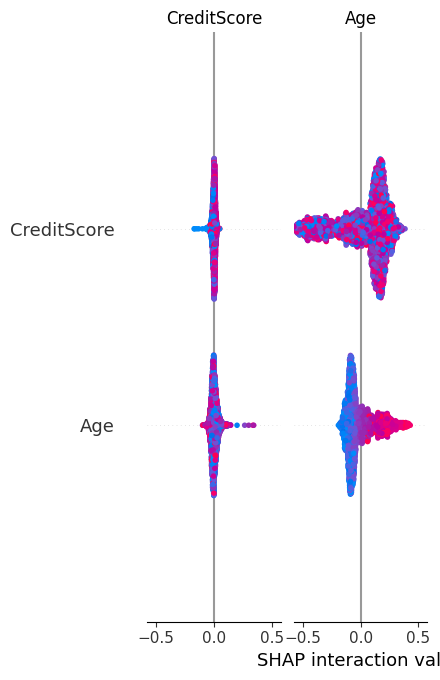

In [14]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(best_rf_model)

# Get SHAP values
shap_values = explainer.shap_values(X_test)

# If it's a binary classification, SHAP may return a list of arrays
# Select shap values for class 1 (index 1) for binary classification
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# Check the shape of SHAP values and X_test
print(f"Shape of SHAP values: {shap_values.shape}")
print(f"Shape of X_test: {X_test.shape}")

# Ensure the shapes match
assert shap_values.shape[0] == X_test.shape[0], "Mismatch in the number of samples"
assert shap_values.shape[1] == X_test.shape[1], "Mismatch in the number of features"

# Summary plot for the selected class
shap.summary_plot(shap_values, X_test, feature_names=X.columns)



In [16]:
# Save the model as a pickle file
import pickle
model_filename = 'best_rf_model.pkl'

# Open a file in write-binary mode and save the model
with open(model_filename, 'wb') as file:
    pickle.dump(best_rf_model, file)
